In [39]:
!pip install pandas openpyxl xgboost scikit-learn matplotlib seaborn

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB 326.8 kB/s eta 0:00:25
    --------------------------------------- 0.1/8.1 MB 726.2 kB/s eta 0:00:11
    --------------------------------------- 0.2/8.1 MB 833.5 kB/s eta 0:00:10
   - -------------------------------------- 0.3/8.1 MB 1.0 MB/s eta 0:00:08
   -- ------------------------------------- 0.5/8.1 MB 1.6 MB/s eta 0:00:05
   -- ------------------------------------- 0.6/8.1 MB 1.7 MB/s eta 0:00:05
   --- ------------------------------------ 0.7/8.1 MB 2.0 MB/s eta 0:00:04
   ---- ----------------------------------- 0.9/8.1 MB 2.0 MB/s eta 0:00:04
   ----- ---------------------------------- 1.1/8.1 MB 2.3 MB/s eta 0:00:04
   ----- ---------------------------------- 1.2/8.1 MB 2.3 MB/s eta 0:00:04
   ------ -----------------

ERROR: Could not install packages due to an OSError: [WinError 5] Odmowa dostępu: 'C:\\Users\\JCzapla\\AppData\\Local\\anaconda3\\Lib\\site-packages\\matplotlib\\backends\\_backend_agg.cp311-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [46]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import plot_importance

**PREPROCESSING**

In [4]:
df1 = pd.read_csv('cs-training.csv')
df2 = pd.read_csv('cs-test.csv')

# Łączenie dwóch podzbiorów danych w jeden
df = pd.concat([df1, df2], axis=0, ignore_index=True)

new_column_names = {
    'SeriousDlqin2yrs': 'SD2Y',
    'RevolvingUtilizationOfUnsecuredLines': 'RUUL',
    'age': 'Age',
    'NumberOfTime30-59DaysPastDueNotWorse': 'N3059DPD',
    'DebtRatio': 'DR',
    'MonthlyIncome': 'MI',
    'NumberOfOpenCreditLinesAndLoans': 'NOCLL',
    'NumberOfTimes90DaysLate': 'N90DL',
    'NumberRealEstateLoansOrLines': 'NRELL',
    'NumberOfTime60-89DaysPastDueNotWorse': 'N6089DPD',
    'NumberOfDependents': 'ND'
}

# Zmiana nazwy kolumn
df.rename(columns=new_column_names, inplace=True)
df.drop(columns='Unnamed: 0', inplace=True)
df.head(20)

,SD2Y,RUUL,Age,N3059DPD,DR,MI,NOCLL,N90DL,NRELL,N6089DPD,ND
0,1.0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0.0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0.0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0.0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0.0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,0.0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,0.0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
7,0.0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
8,0.0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
9,0.0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0


In [5]:
print(df.dtypes)
df.shape

SD2Y        float64
RUUL        float64
Age           int64
N3059DPD      int64
DR          float64
MI          float64
NOCLL         int64
N90DL         int64
NRELL         int64
N6089DPD      int64
ND          float64
dtype: object


(251503, 11)

In [6]:
# Sprawdzenie, czy są duplikaty
duplikaty = df.duplicated()
liczba_duplikatow = duplikaty.sum()

print(f'Liczba duplikatów: {liczba_duplikatow}')

Liczba duplikatów: 937


In [7]:
# Usunięcie duplikatów
df = df.drop_duplicates()

# Sprawdzenie liczby duplikatów po usunięciu
nowa_liczba_duplikatow = df.duplicated().sum()
print(f'Liczba duplikatów po usunięciu: {nowa_liczba_duplikatow}')

Liczba duplikatów po usunięciu: 0


In [8]:
df.isna().sum()

SD2Y        101175
RUUL             0
Age              0
N3059DPD         0
DR               0
MI           49047
NOCLL            0
N90DL            0
NRELL            0
N6089DPD         0
ND            6394
dtype: int64

In [9]:
# Obliczenie udziału braków danych dla każdej kolumny
missing_percentage = (df.isna().sum() / len(df)) * 100
print(missing_percentage)

# eksport do pliku Excel
missing_df = missing_percentage.reset_index()
missing_df.columns = ['Column', 'Missing Percentage']
missing_df.to_excel('missing_data_percentage.xlsx', index=False)

SD2Y        40.378583
RUUL         0.000000
Age          0.000000
N3059DPD     0.000000
DR           0.000000
MI          19.574483
NOCLL        0.000000
N90DL        0.000000
NRELL        0.000000
N6089DPD     0.000000
ND           2.551823
dtype: float64


In [10]:
train_data = df.dropna(subset=['SD2Y'])
missing_data = df[df['SD2Y'].isna()]

# Podział na cechy i zmienną docelową
X_train = train_data.drop(columns="SD2Y")
y_train = train_data['SD2Y']
X_missing = missing_data.drop(columns="SD2Y")

# Trenowanie modelu
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Predykcja braków
missing_predictions = model.predict(X_missing)

# Uzupełnienie braków i zaokrąglenie do 0 lub 1
df.loc[df['SD2Y'].isna(), 'SD2Y'] = missing_predictions.round()

In [11]:
train_data = df.dropna(subset=['MI'])
missing_data = df[df['MI'].isna()]

# Podział na cechy i zmienną docelową
X_train = train_data.drop(columns="MI")
y_train = train_data['MI']
X_missing = missing_data.drop(columns="MI")

# Trenowanie modelu
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Predykcja braków
missing_predictions = model.predict(X_missing)

# Uzupełnienie braków
df.loc[df['MI'].isna(), 'MI'] = missing_predictions

In [12]:
df = df.dropna(subset=['ND'])

In [13]:
missing_percentage = (df.isna().sum() / len(df)) * 100
print(missing_percentage)

SD2Y        0.0
RUUL        0.0
Age         0.0
N3059DPD    0.0
DR          0.0
MI          0.0
NOCLL       0.0
N90DL       0.0
NRELL       0.0
N6089DPD    0.0
ND          0.0
dtype: float64


In [14]:
df.shape

(244172, 11)

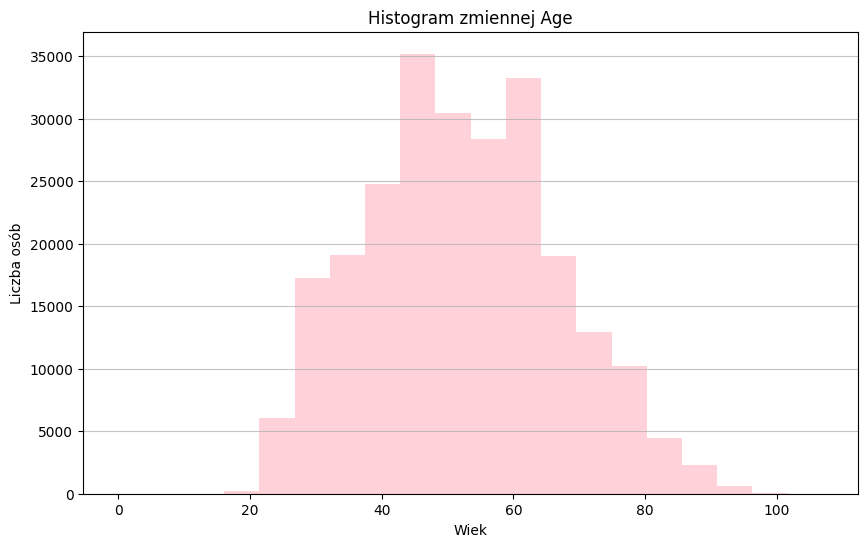

In [15]:
# histogram zmiennej Age
plt.figure(figsize=(10, 6))
plt.hist(df['Age'], bins=20, color='pink', alpha=0.7)
plt.title('Histogram zmiennej Age')
plt.xlabel('Wiek')
plt.ylabel('Liczba osób')
plt.grid(axis='y', alpha=0.75)

plt.savefig('histogram_age.png', format='png', dpi=300)

plt.show()


In [16]:
# Funkcja do winsoryzacji danych
def winsorize_outliers(df):
    winsorized_df = df.copy()
    for col in winsorized_df.select_dtypes(include=[np.number]).columns:
        lower_bound = winsorized_df[col].quantile(0.01)
        upper_bound = winsorized_df[col].quantile(0.99)
        winsorized_df[col] = np.where(winsorized_df[col] < lower_bound, lower_bound, winsorized_df[col])
        winsorized_df[col] = np.where(winsorized_df[col] > upper_bound, upper_bound, winsorized_df[col])
    return winsorized_df

# Wykonanie winsoryzacji danych
winsorized_data = winsorize_outliers(df)

# Wyświetlenie wyników winsoryzacji
print("Winsoryzowane dane:")
print(winsorized_data)

Winsoryzowane dane:
        SD2Y      RUUL   Age  N3059DPD           DR        MI  NOCLL  N90DL  \
0        1.0  0.766127  45.0       2.0     0.802982   9120.00   13.0    0.0   
1        0.0  0.957151  40.0       0.0     0.121876   2600.00    4.0    0.0   
2        0.0  0.658180  38.0       1.0     0.085113   3042.00    2.0    1.0   
3        0.0  0.233810  30.0       0.0     0.036050   3300.00    5.0    0.0   
4        0.0  0.907239  49.0       1.0     0.024926  23750.00    7.0    0.0   
...      ...       ...   ...       ...          ...       ...    ...    ...   
251497   0.0  0.045230  67.0       0.0     0.012198   5000.00    4.0    0.0   
251498   0.0  0.282653  24.0       0.0     0.068522   1400.00    5.0    0.0   
251499   0.0  0.922156  36.0       3.0     0.934217   7615.00    8.0    0.0   
251501   0.0  0.335457  56.0       0.0  3568.000000      0.06    8.0    0.0   
251502   0.0  0.441842  29.0       0.0     0.198918   5916.00   12.0    0.0   

        NRELL  N6089DPD   ND  


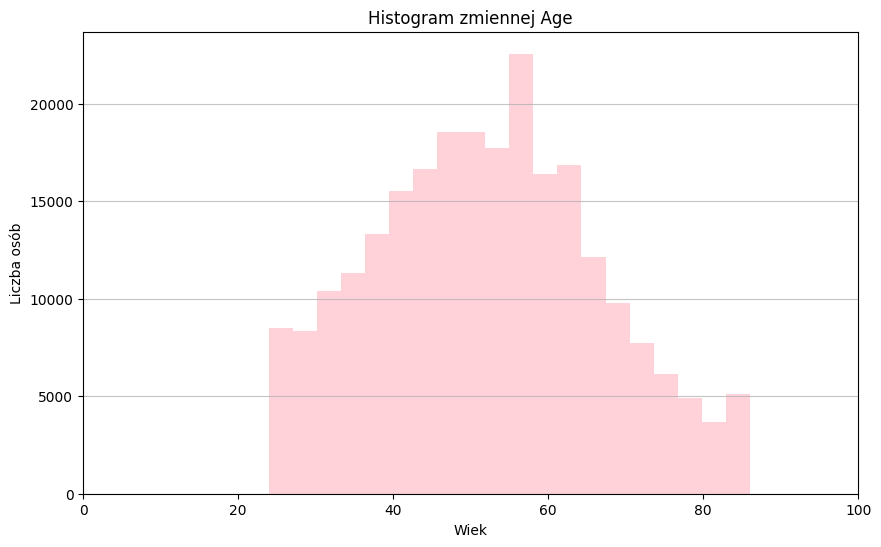

In [17]:
# histogram zmiennej Age
plt.figure(figsize=(10, 6))
plt.hist(winsorized_data['Age'], bins=20, color='pink', alpha=0.7)
plt.title('Histogram zmiennej Age')
plt.xlabel('Wiek')
plt.ylabel('Liczba osób')
plt.grid(axis='y', alpha=0.75)

plt.xticks(range(0, 101, 20))

plt.savefig('histogram_age2.png', format='png', dpi=300)

plt.show()


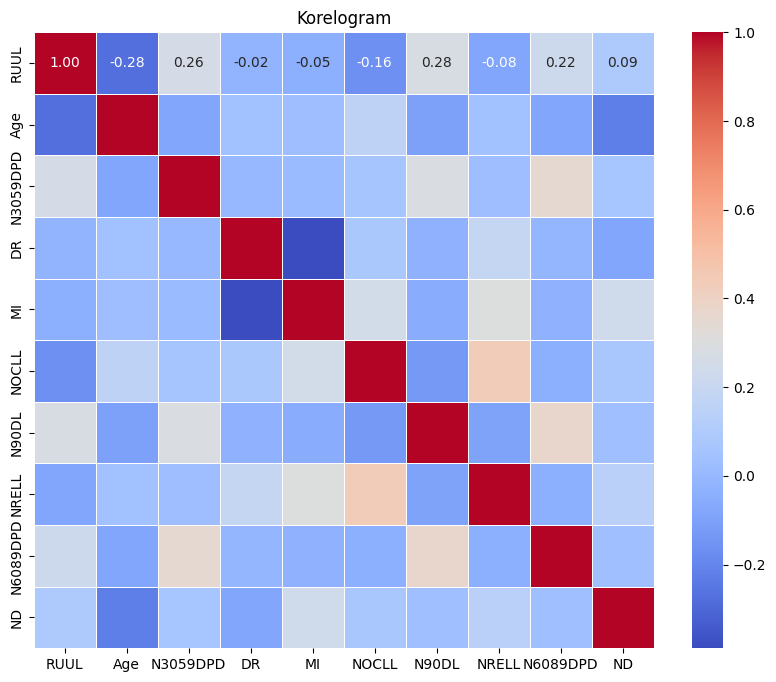

In [18]:
winsorized_data_without_SD2Y = winsorized_data.drop(columns=['SD2Y'])

# Obliczenie macierzy korelacji dla zmiennych ilościowych
correlation_matrix = winsorized_data_without_SD2Y.corr()

# Wykres korelogramu
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Korelogram')
plt.savefig('korelogram.png', dpi=300, bbox_inches='tight')
plt.show()

# Eksport macierzy korelacji do pliku Excel
correlation_matrix.to_excel('macierz_korelacji.xlsx', sheet_name='Korelacje')


In [19]:
# Obliczanie podstawowych statystyk
statistics = winsorized_data.describe()
print(statistics)

                SD2Y           RUUL            Age       N3059DPD  \
count  244172.000000  244172.000000  244172.000000  244172.000000   
mean        0.050641       0.322398      52.134626       0.248751   
std         0.219263       0.351329      14.462684       0.668700   
min         0.000000       0.000000      24.000000       0.000000   
25%         0.000000       0.031246      41.000000       0.000000   
50%         0.000000       0.157979      52.000000       0.000000   
75%         0.000000       0.563107      62.000000       0.000000   
max         1.000000       1.091731      86.000000       4.000000   

                  DR             MI          NOCLL          N90DL  \
count  244172.000000  244172.000000  244172.000000  244172.000000   
mean      299.531176    5266.645806       8.511476       0.086464   
std       888.157070    4562.657236       4.966853       0.400160   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.173152    2025.0000

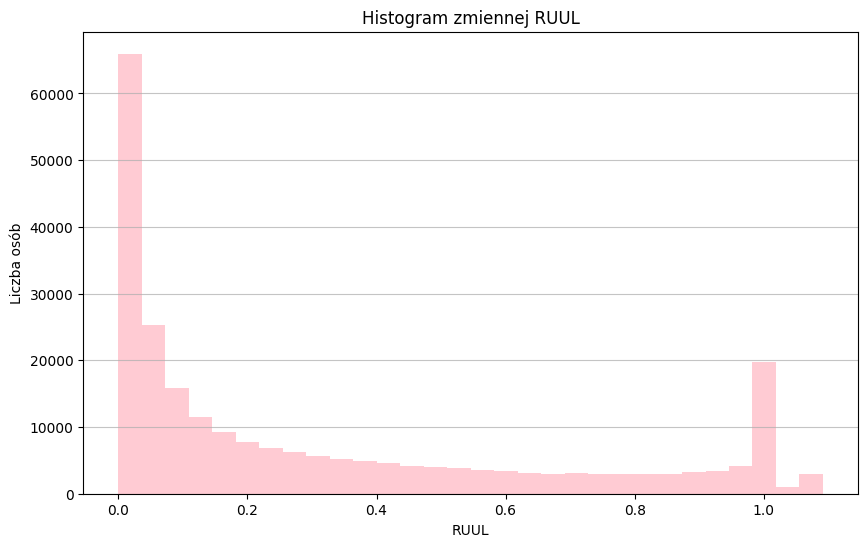

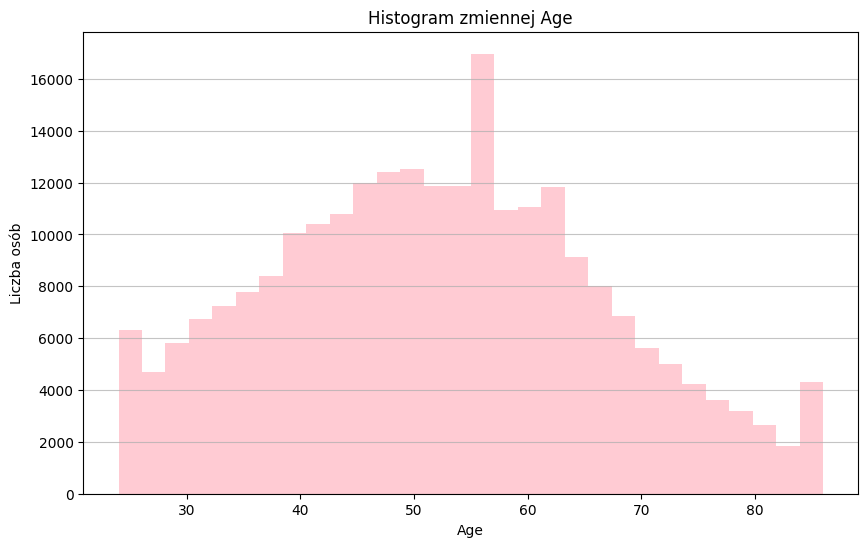

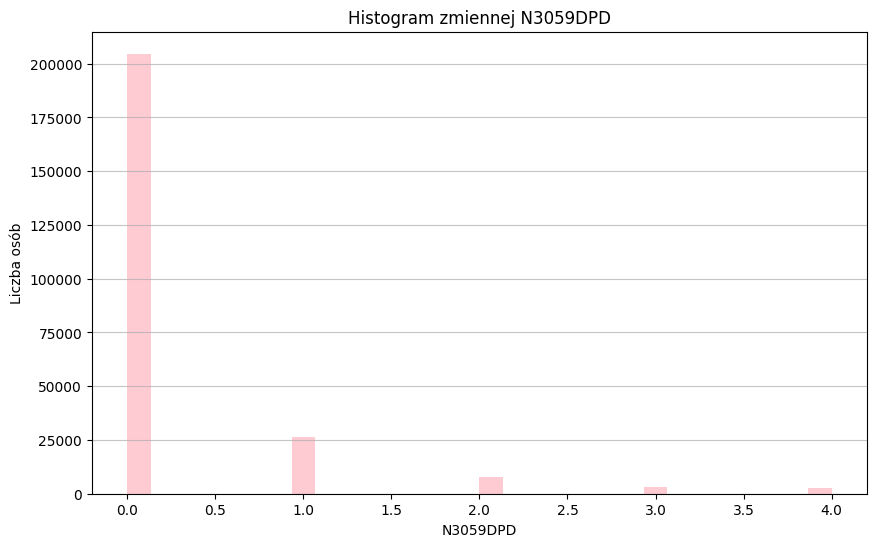

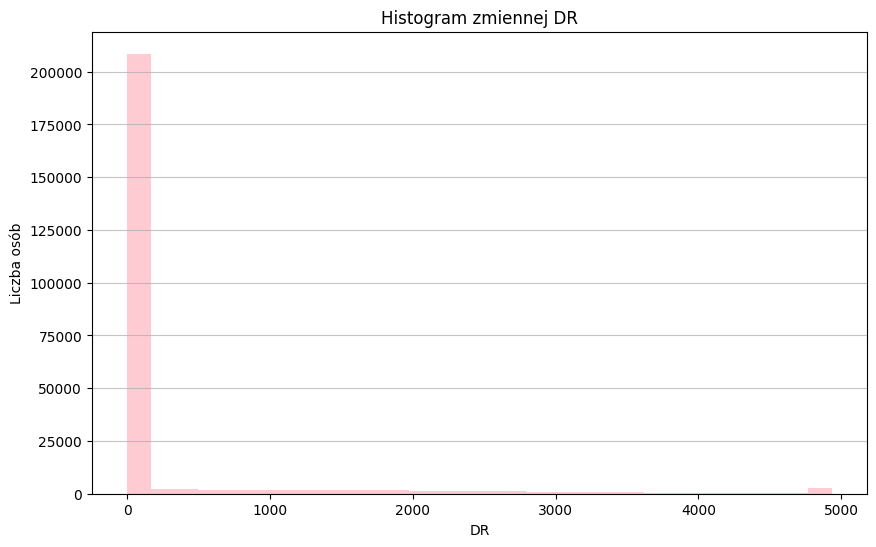

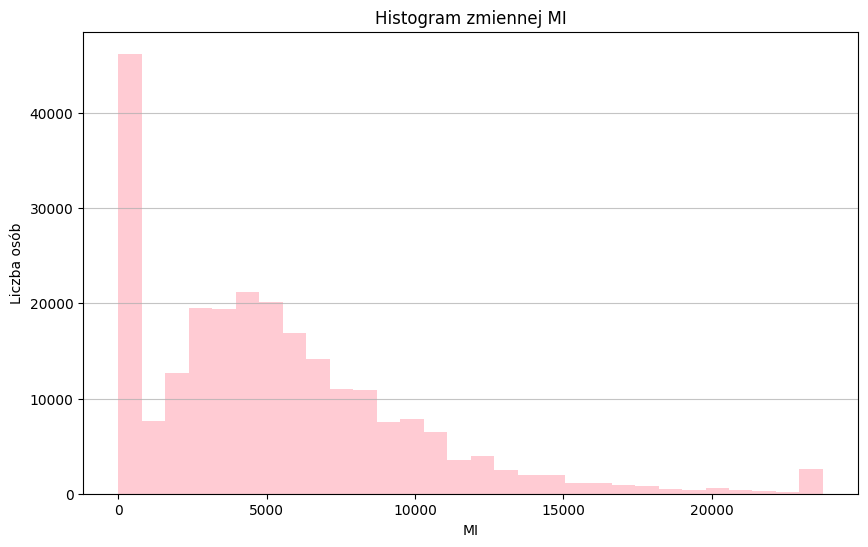

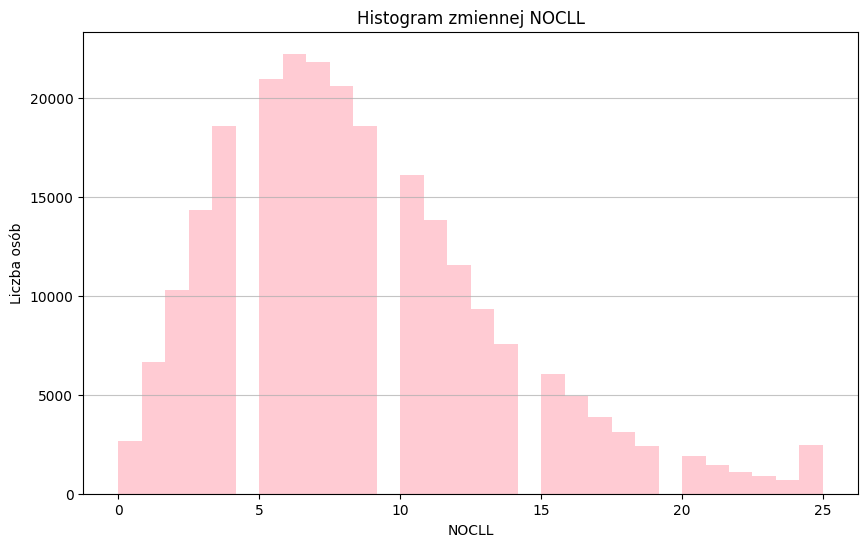

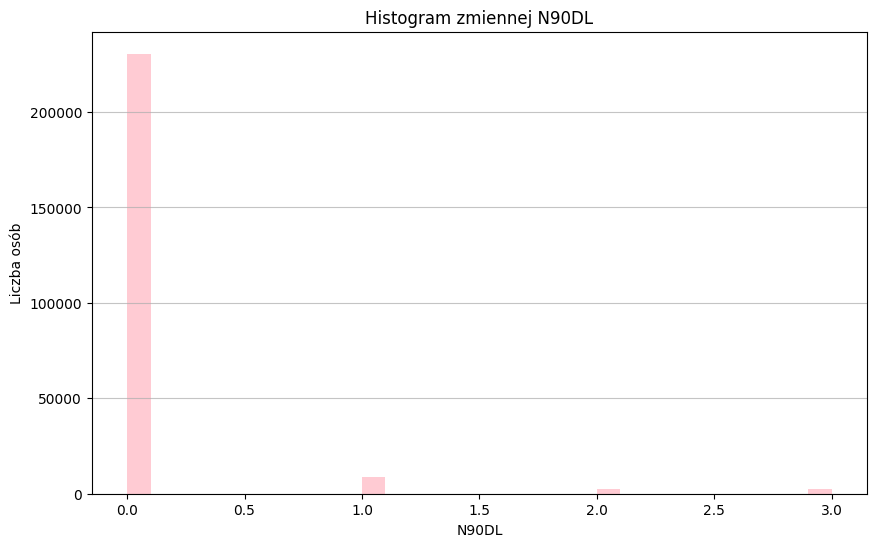

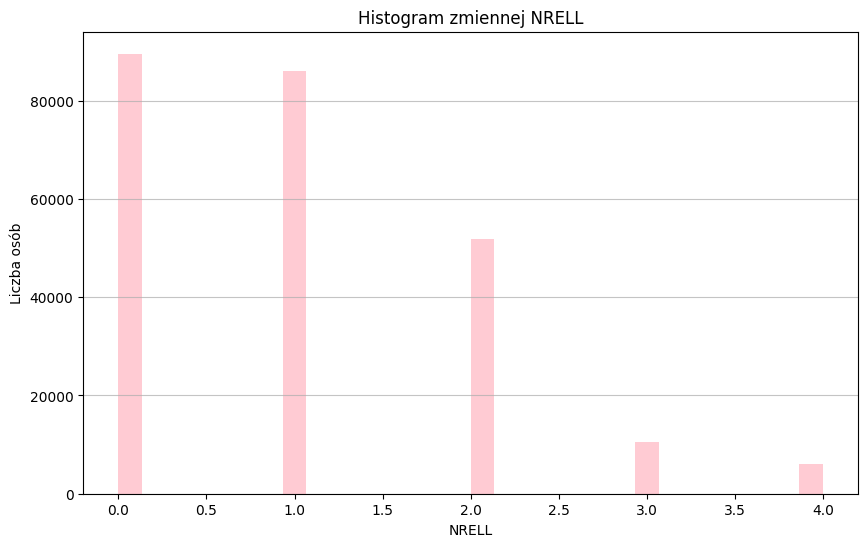

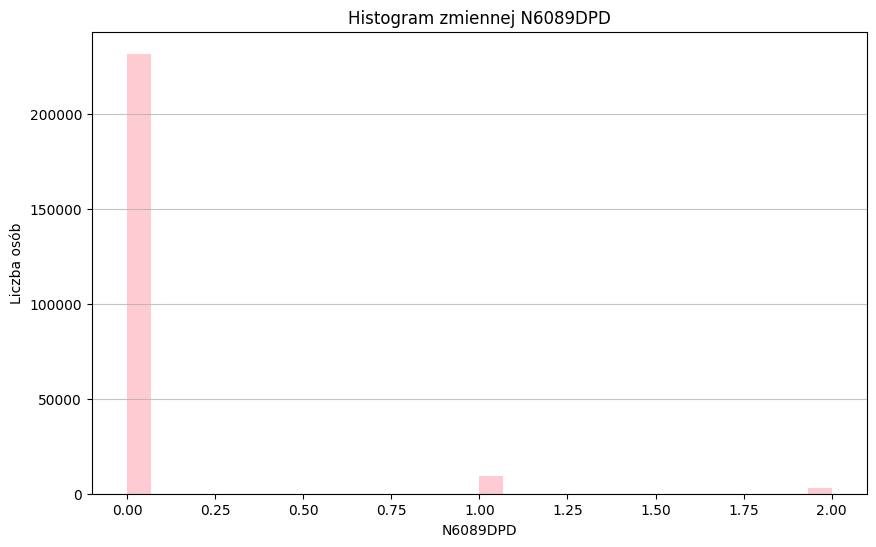

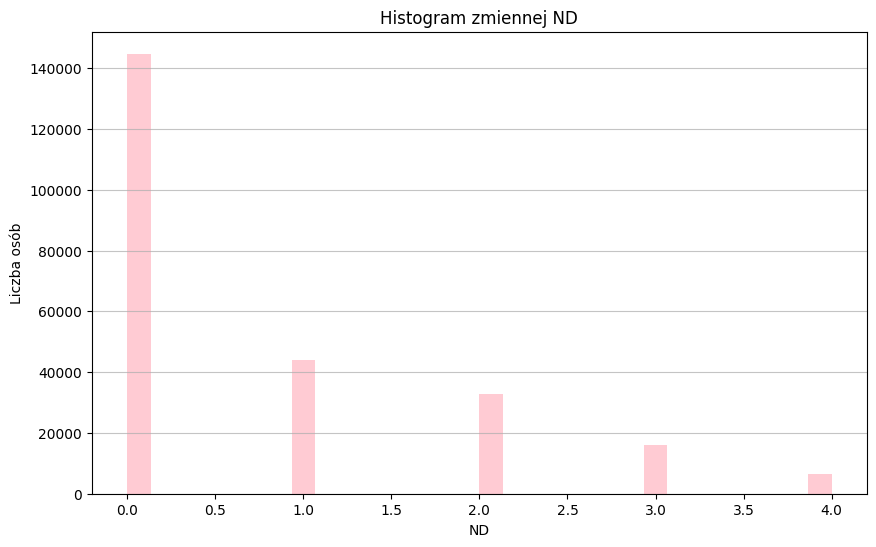

In [20]:
# Histogramy zmiennych objaśniających
variables = winsorized_data.columns.tolist()
variables.remove('SD2Y')

for var in variables:
    plt.figure(figsize=(10, 6))
    counts, bins, patches = plt.hist(winsorized_data[var], bins=30, color='lightpink', alpha=0.7)
    
    plt.title(f'Histogram zmiennej {var}')
    plt.xlabel(var)
    plt.ylabel('Liczba osób')
    plt.grid(axis='y', alpha=0.75)

    plt.savefig(f'histogram_{var}.png', format='png', dpi=300)
    
    plt.show()

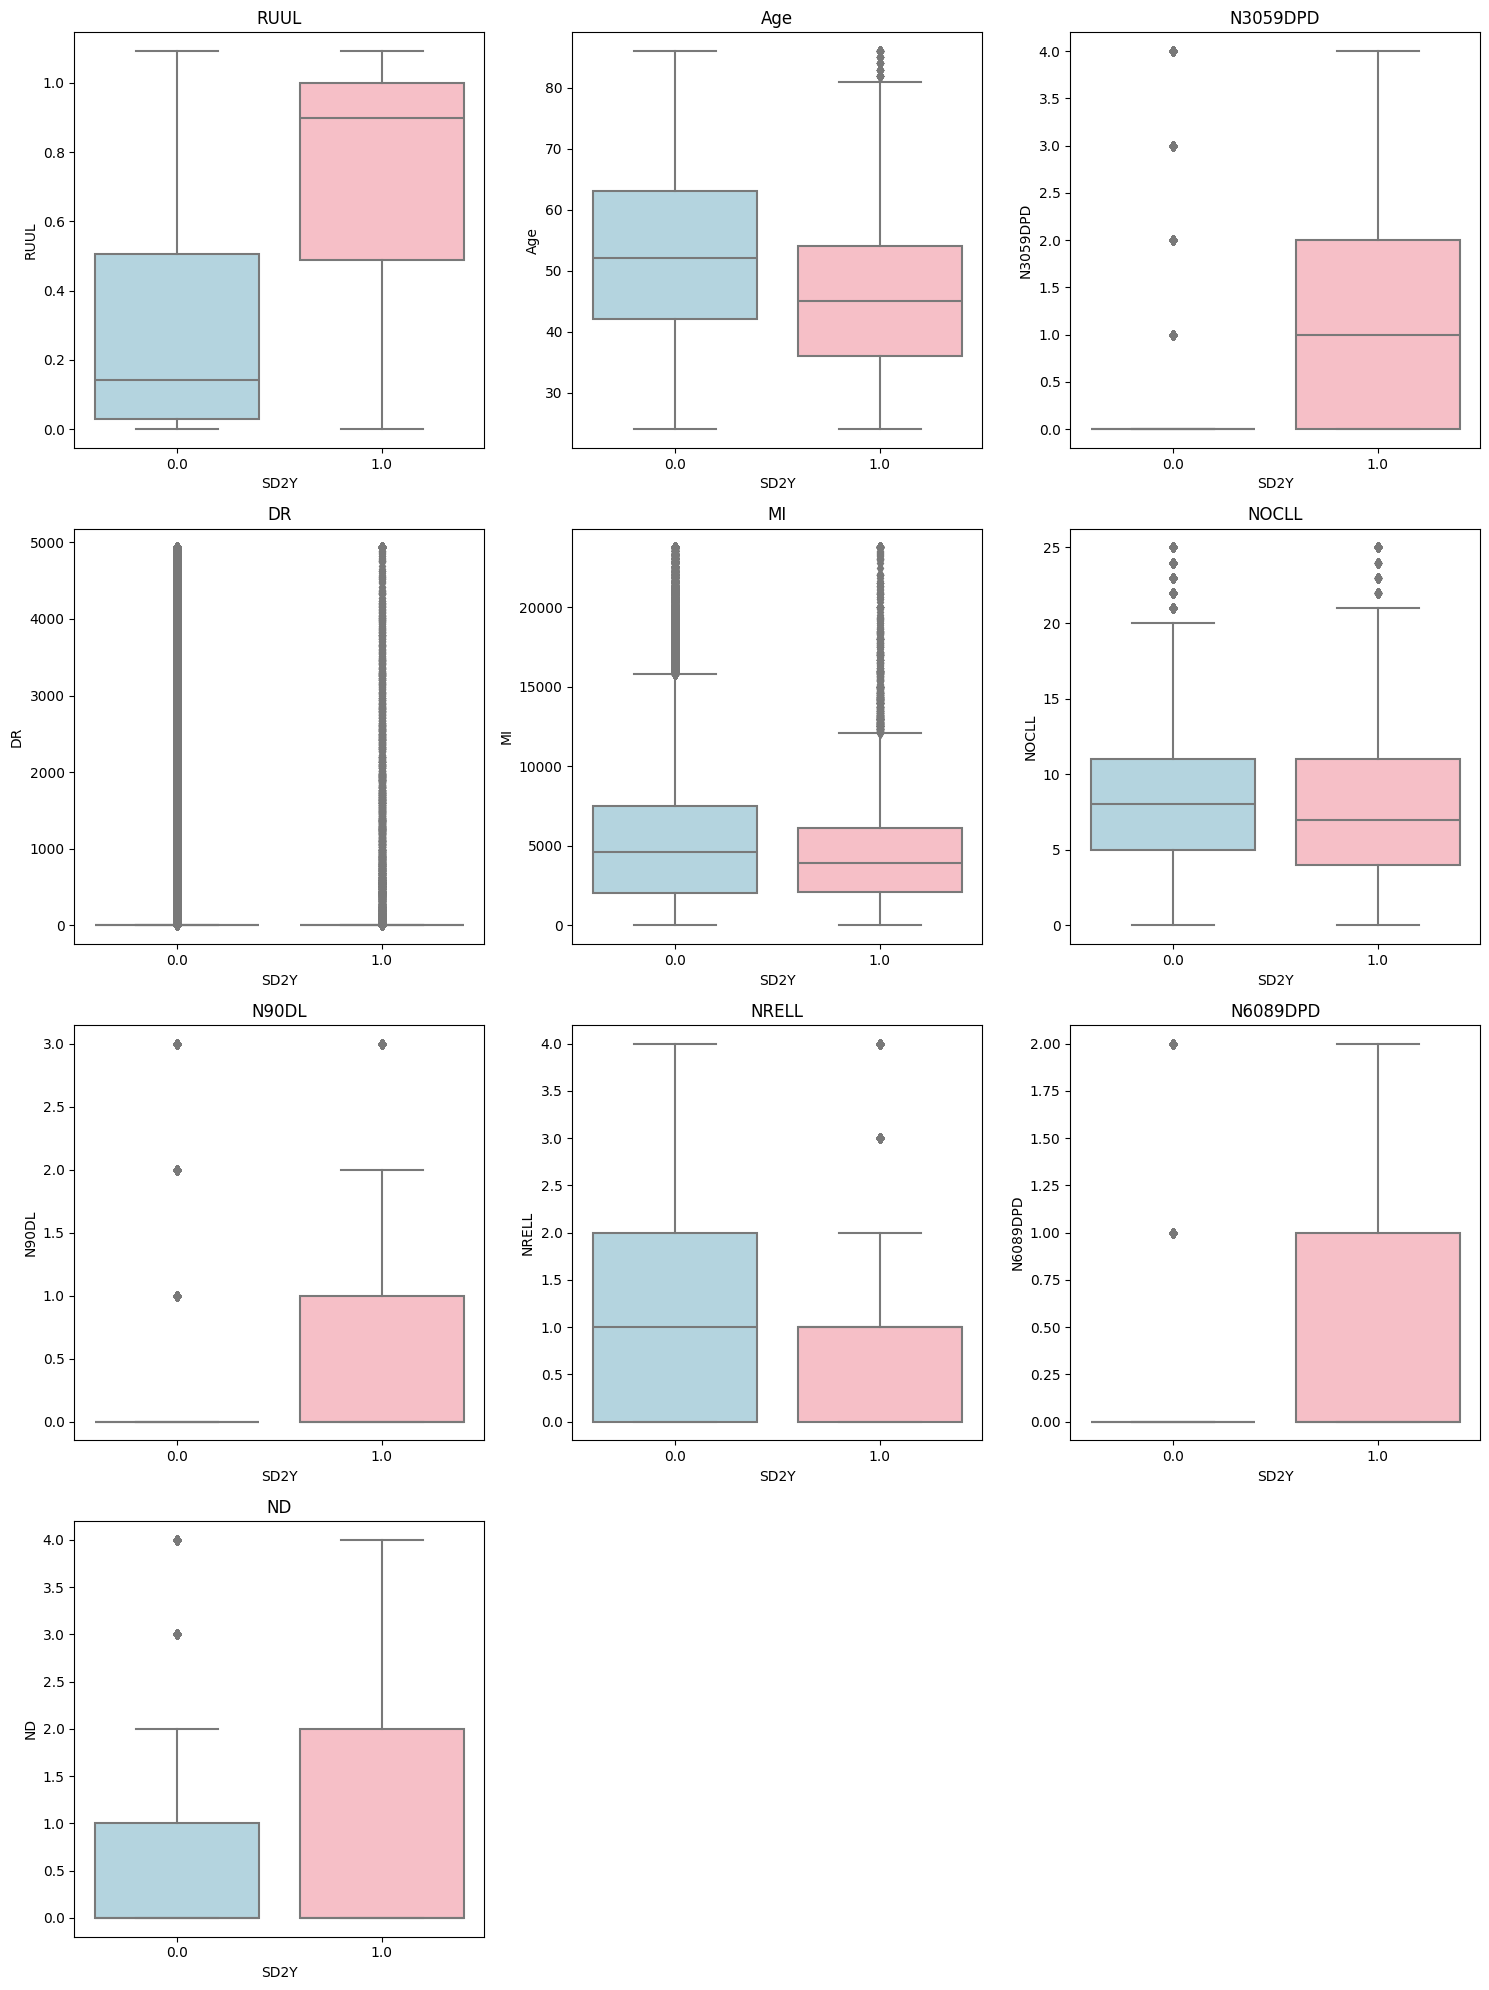

In [21]:
# Wykresy pudełkowe względem zmiennej celu
variables = winsorized_data.columns.tolist()
variables.remove('SD2Y')

n_vars = len(variables)
cols = 3
rows = np.ceil(n_vars / cols).astype(int)

plt.figure(figsize=(15, rows * 5)) 

for i, var in enumerate(variables):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(x='SD2Y', y=var, data=winsorized_data, 
                palette={0: 'lightblue', 1: 'lightpink'}) 
    plt.title(var)
    plt.xlabel('SD2Y')
    plt.ylabel(var)

plt.tight_layout()

plt.savefig('boxplots.png', dpi=300)

plt.show()


In [22]:
# Rozdzielenie danych na cechy (X) i etykiety (y)
X = winsorized_data.drop(columns=['SD2Y'])
y = winsorized_data['SD2Y']

In [23]:
unique, count = np.unique(y, return_counts=True)
y_dict_value_count = { k:v for (k,v) in zip(unique,count) }
y_dict_value_count

{0.0: 231807, 1.0: 12365}

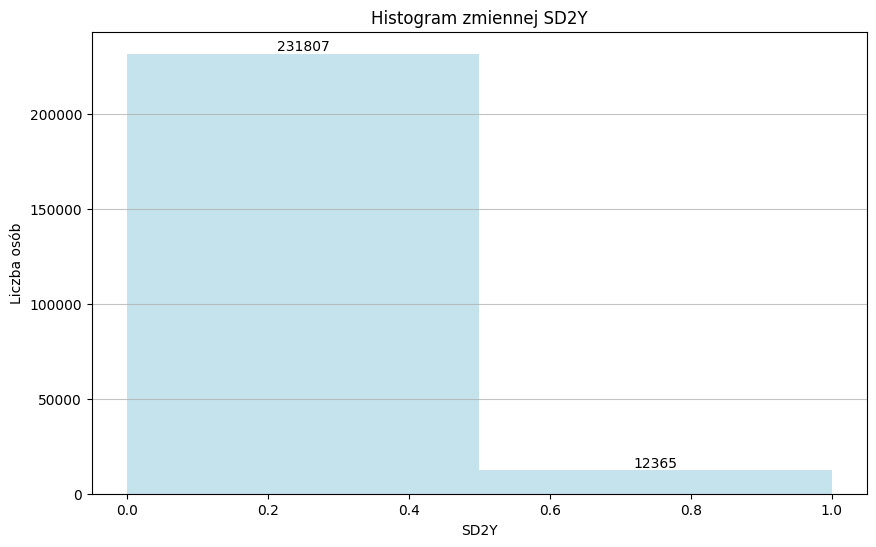

In [24]:
# Histogram zmiennej SD2Y
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(winsorized_data['SD2Y'], bins=2, color='lightblue', alpha=0.7)

bin_width = bins[1] - bins[0]

for count, x in zip(counts, bins):
    height = count
    plt.text(x + bin_width / 2, height, str(int(height)), ha='center', va='bottom')

plt.title('Histogram zmiennej SD2Y')
plt.xlabel('SD2Y')
plt.ylabel('Liczba osób')
plt.grid(axis='y', alpha=0.75)

plt.savefig('histogram_SD2Y.png', format='png', dpi=300)

plt.show()


In [25]:
# Inicjalizacja SMOTE
sm = SMOTE(random_state=42, sampling_strategy='auto')

# Zastosowanie SMOTE do danych
X_res, y_res = sm.fit_resample(X, y)

In [26]:
unique, count = np.unique(y_res, return_counts=True)
y_smote_value_count = { k:v for (k,v) in zip(unique,count) }
y_smote_value_count

{0.0: 231807, 1.0: 231807}

In [27]:
# Podział na zestaw treningowy (70%) i testowy (30%)
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

In [28]:
# Zapis przetworzonych danych
train_data = pd.DataFrame(X_train_u)
train_data['target'] = y_train_u

test_data = pd.DataFrame(X_test_u)
test_data['target'] = y_test_u

with pd.ExcelWriter('zbiory_danych.xlsx') as writer:
    train_data.to_excel(writer, sheet_name='Zbior_treningowy', index=False)
    test_data.to_excel(writer, sheet_name='Zbior_testowy', index=False)

**MODEL BOOSTING**

In [29]:
file_path = 'zbiory_danych.xlsx'
train_df = pd.read_excel(file_path, sheet_name='Zbior_treningowy')
test_df = pd.read_excel(file_path, sheet_name='Zbior_testowy')

In [30]:
X_train = train_df.drop(columns=['target'])
y_train = train_df['target']

In [31]:
X_test = test_df.drop(columns=['target'])
y_test = test_df['target']

In [35]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

print("XGBClassifier trained successfully.")

XGBClassifier trained successfully.


In [40]:
 xgb.to_graphviz(model, num_trees=0).render("tree")

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [41]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [42]:
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f'Accuracy: {acc:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print('Confusion Matrix:')
print(cm)

Accuracy: 0.9736
ROC AUC: 0.9935
Confusion Matrix:
[[68849   655]
 [ 3016 66565]]


Accuracy: 0.9736
ROC AUC: 0.9935


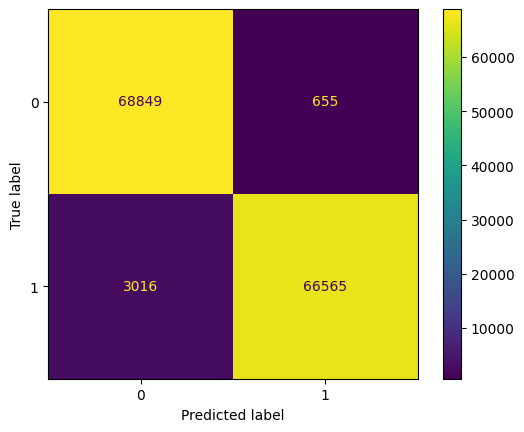

In [44]:
print(f'Accuracy: {acc:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


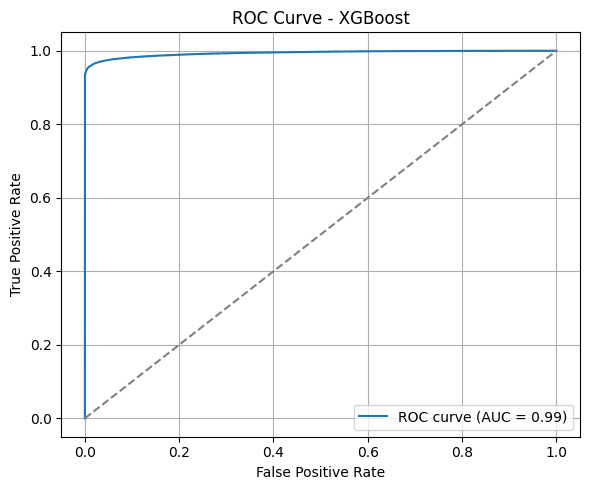

In [45]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

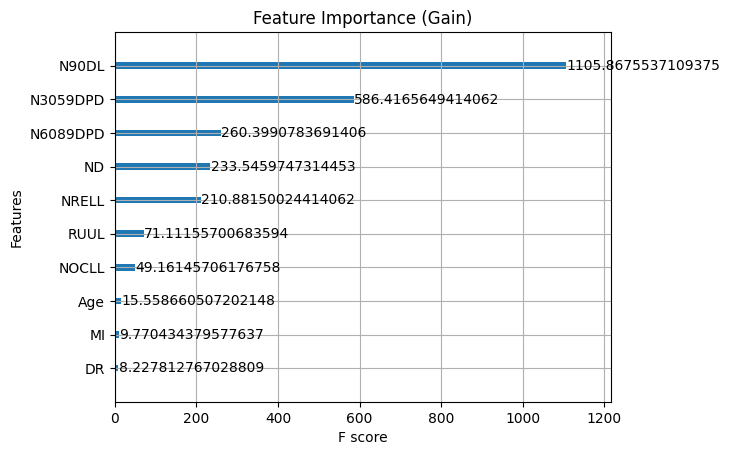

In [47]:
plot_importance(model, max_num_features=10, importance_type='gain')
plt.title('Feature Importance (Gain)')
plt.show()

Bagging

In [ ]:
file_path = r"C:\Users\alcze\OneDrive\Pulpit\zbiory_danych.xlsx"
train_df = pd.read_excel(file_path, sheet_name='Zbior_treningowy')
test_df = pd.read_excel(file_path, sheet_name='Zbior_testowy')

In [ ]:
X_train = train_df.drop(columns=['target'])
y_train = train_df['target']

In [ ]:
X_test = test_df.drop(columns=['target'])
y_test = test_df['target']

In [ ]:
#Bagging Clasifier
bagging_model = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

In [ ]:
bagging_model.fit(X_train, y_train)

In [ ]:
from sklearn.base import clone

shallow_original = min(bagging_model.estimators_, key=lambda est: est.get_depth())
shallow_trimmed = DecisionTreeClassifier(max_depth=4, random_state=42)
shallow_trimmed.fit(X_train, y_train)  

plt.figure(figsize=(15, 8))
plot_tree(
    shallow_trimmed,
    feature_names=list(X_train.columns),
    class_names=["brak defaultu", "default"],
    filled=True
)
plt.title("Uproszczone drzewo (max_depth=4)")
plt.show()


In [ ]:
y_pred = bagging_model.predict(X_test)
y_proba = bagging_model.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f'Accuracy: {acc:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print('Confusion Matrix:')
print(cm)

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - BaggingClassifier')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()